# Notes:

Recall that in linear regression:
- The design matrix is equal to $J_n = \frac1n \sum_{i=1}^n x_i^2$. 
- In a fixed population, the data defect correlation is proportional to $\textrm{Cov}(R, G^*)/\sigma_R$, where $G^*(x, y) = x(y - \beta^* x)$, and where $\beta^*$ is the finite population OLS fit.
- In the scenario below, where the finite population points are a grid, this simplifies greatly, as:
    - $\beta^* = 0$.
    - $G^*(X, Y) = XY$.
    - $E_I[G^*(X_I, Y_I)] = 0$.
    - $\textrm{Cov}(R, G^*) = E_I[R_IX_IY_I]$.

Therefore, in this case, the ddc is proportional to:
$$\rho_{R, G^*} \propto \frac{\sum_I R_IX_IY_I}{\sqrt{n(N-n)}}.$$

Suppose that we want to design an example where the ddc are the same, but the design matrices are different, and the sample sizes are also different.
- For simplicitly, we can consider samples where the denominator $\sqrt{n(N-n)}$ factors out nicely. For 25 datapoints, this occurs nicely for $n = 5, 9$, giving denominators of $10$ and $12$. Letting the above to equal 1/2, we see that the graph2_samples below works.

# Imports:

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

In [3]:
def professional_plot_layout(fig):
    return fig.update_layout(
        template="simple_white",  # clean background
        # font=dict(family="Times New Roman", size=14),  # journal-friendly
        legend=dict(
            title=None, orientation="h", y=-0.2, x=0.5, xanchor="center"  # below plot
        ),
        margin=dict(l=60, r=20, t=20, b=60),
    )

In [4]:
def concatenate_lists(list_of_lists):
    """Concatenates a list of lists using list comprehension."""
    return [item for sublist in list_of_lists for item in sublist]

In [5]:
def corr_with_ddof(df: pd.DataFrame, ddof: int = 1) -> pd.DataFrame:
    """
    Compute correlation matrix for a DataFrame with a custom ddof.

    Parameters
    ----------
    df : pd.DataFrame
        Input data (numeric only).
    ddof : int, default=1
        Delta degrees of freedom to use in variance/covariance.

    Returns
    -------
    pd.DataFrame
        Correlation matrix.
    """
    # ensure numeric data only
    df_num = df.select_dtypes(include=[np.number])
    
    # center the data
    X = df_num.to_numpy(dtype=float)
    X_centered = X - X.mean(axis=0)
    
    # covariance with custom ddof
    n = X.shape[0]
    cov = (X_centered.T @ X_centered) / (n - ddof)
    
    # standard deviations
    std = np.sqrt(np.diag(cov))
    
    # correlation
    corr = cov / np.outer(std, std)
    
    return pd.DataFrame(corr, index=df_num.columns, columns=df_num.columns)

# Hyperparams:

In [6]:
n = 2

In [7]:
# all (x, y) combos
graph1_samples = [[(-1, -2), (0, 0), (1, 2)], [(-1, -1), (0, 0), (1, 1)]]

# graph2_samples = [[(-1, -2), (0, 0), (1, 2)], [(-2, -1), (0, 0), (2, 1)]]
graph2_samples = [[(-2, 2), (-2, -1), (-2, -2), (1, 1), (1, 2)], [(-1, 1), (-1, -1), (-1, -2), (0, 0), (0, -1), (1, 2), (1, 1), (1, -1), (2, 1)]]


# Run:

## orig: (with color)

In [ ]:
df = pd.DataFrame({
    "X": [i for i in range(-n, n+1)] * (2*n+1),
    "Y": concatenate_lists([[i for _ in range((2*n+1))] for i in range(-n, n+1)])
})

# Function to encode memberships for plotting
def get_membership(df, sample_shape, sample_fill, fill_color: str = 'blue', fill_shape: str = 'D', other_linestyle: str = 'dotted'):
    shapes = []
    facecolors = []
    linestyles = []
    
    for temp_index, temp_row in df.iterrows():
        temp_datapoint = (temp_row['X'], temp_row['Y'])
        shapes.append(fill_shape if temp_datapoint in sample_shape else "o")
        facecolors.append(fill_color if temp_datapoint in sample_fill else "none")
        linestyles.append("solid" if temp_datapoint in sample_shape else other_linestyle)
    return shapes, facecolors, linestyles

shapes_left, faces_left, lstyles_left = get_membership(df, graph1_samples[0], graph1_samples[1])
shapes_right, faces_right, lstyles_right = get_membership(df, graph2_samples[0], graph2_samples[1], fill_color='orange')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Left plot (A/B)
for x, y, m, f, ls in zip(df["X"], df["Y"], shapes_left, faces_left, lstyles_left):
    axes[0].scatter(x, y, s=90, marker=m, facecolor=f, edgecolor="black", linewidth=1, linestyle=ls)
axes[0].set_title("Same Design Matrix, Different DDC")

# Right plot (C/D)
for x, y, m, f, ls in zip(df["X"], df["Y"], shapes_right, faces_right, lstyles_right):
    axes[1].scatter(x, y, s=90, marker=m, facecolor=f, edgecolor="black", linewidth=1, linestyle=ls)
axes[1].set_title("Different Design Matrix, Same DDC")

for ax in axes:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal', adjustable='box')
    
    # ---- Clean up ticks ----
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
# Shared legend (optional)
# legend_elems = [
#     plt.Line2D([0],[0], marker="s", color="black", markerfacecolor="none", markersize=10, label="Shape category only"),
#     plt.Line2D([0],[0], marker="o", color="black", markerfacecolor="gray", markersize=10, label="Fill category only"),
#     plt.Line2D([0],[0], marker="s", color="black", markerfacecolor="gray", markersize=10, label="Shape + Fill"),
#     plt.Line2D([0],[0], marker="o", color="black", markerfacecolor="none", markersize=10, label="Neither")
# ]
# axes[1].legend(handles=legend_elems, frameon=False, title="Membership", loc="upper right")

# Overall figure title
fig.suptitle("Examples of the Design Matrix and Data Defect Correlation in Linear Regression:", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
# plt.show()

fig.savefig("design_vs_ddc_ols_example.jpg", dpi=300, bbox_inches='tight')

## option 2:

C:\Users\chess\AppData\Local\Temp\ipykernel_35396\1537426165.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend


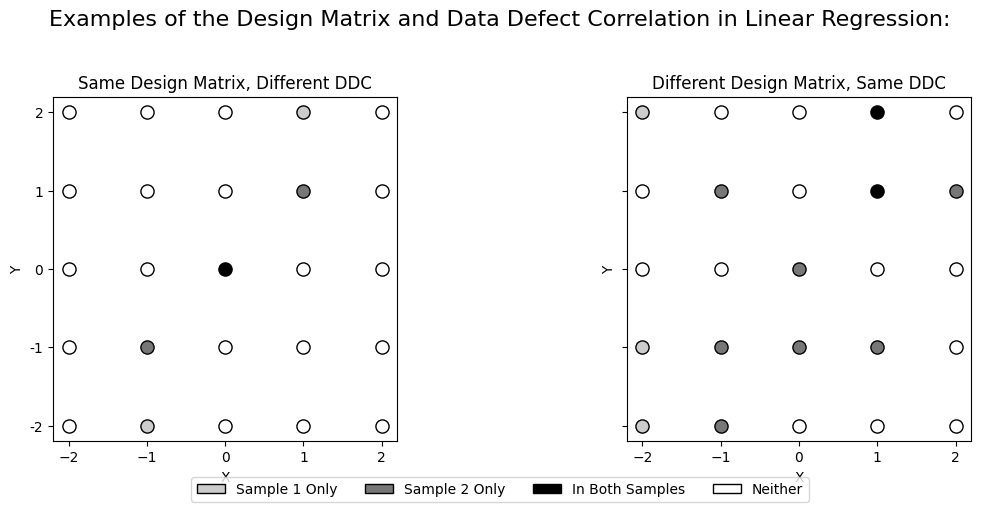

In [36]:
df = pd.DataFrame({
    "X": [i for i in range(-n, n+1)] * (2*n+1),
    "Y": concatenate_lists([[i for _ in range((2*n+1))] for i in range(-n, n+1)])
})

# colors, from lightest to darkest 
C1, C2, C3 = '#CCCCCC', '#777777', '#000000'
# Function to encode memberships for plotting with grayscale
def get_membership_grayscale(df, sample_shape, sample_fill):
    """
    Returns grayscale colors based on membership:
    - Light gray: only in sample_shape
    - Medium gray: only in sample_fill  
    - Dark gray: in both (overlap)
    - White: in neither
    """
    colors = []
    
    for temp_index, temp_row in df.iterrows():
        temp_datapoint = (temp_row['X'], temp_row['Y'])
        in_shape = temp_datapoint in sample_shape
        in_fill = temp_datapoint in sample_fill
        
        if in_shape and in_fill:
            colors.append(C3)  # Black (overlap)
        elif in_shape:
            colors.append(C1)  # Light gray (shape only)
        elif in_fill:
            colors.append(C2)  # Dark gray (fill only)
        else:
            colors.append('white') 
    
    return colors

# Get grayscale colors for both graphs
colors_left = get_membership_grayscale(df, graph1_samples[0], graph1_samples[1])
colors_right = get_membership_grayscale(df, graph2_samples[0], graph2_samples[1])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Left plot (A/B) - use circles with grayscale colors
for x, y, color in zip(df["X"], df["Y"], colors_left):
    axes[0].scatter(x, y, s=90, marker='o', facecolor=color, edgecolor="black", linewidth=1)
axes[0].set_title("Same Design Matrix, Different DDC")

# Right plot (C/D) - use circles with grayscale colors
for x, y, color in zip(df["X"], df["Y"], colors_right):
    axes[1].scatter(x, y, s=90, marker='o', facecolor=color, edgecolor="black", linewidth=1)
axes[1].set_title("Different Design Matrix, Same DDC")

for ax in axes:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal', adjustable='box')
    
    # ---- Clean up ticks ----
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Overall figure title
fig.suptitle("Examples of the Design Matrix and Data Defect Correlation in Linear Regression:", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle

# Optional: Add legend to explain grayscale coding
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=C1, edgecolor='black', label='Sample 1 Only'),
    Patch(facecolor=C2, edgecolor='black', label='Sample 2 Only'),
    Patch(facecolor=C3, edgecolor='black', label='In Both Samples'),
    Patch(facecolor='white', edgecolor='black', label='Neither')
]
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=4, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend
fig.savefig("design_vs_ddc_ols_example_option2.jpg", dpi=300, bbox_inches='tight')

## option 3:

C:\Users\chess\AppData\Local\Temp\ipykernel_35396\716875889.py:87: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend


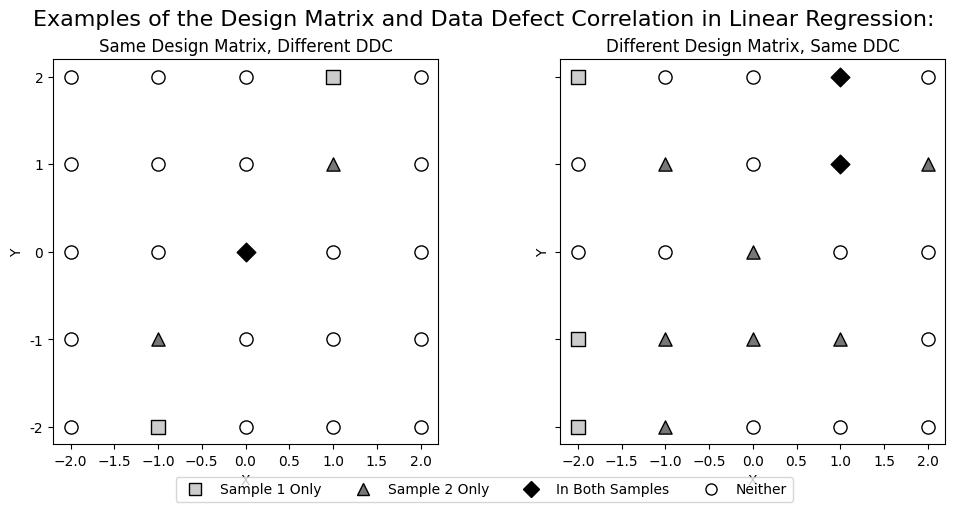

In [32]:
df = pd.DataFrame({
    "X": [i for i in range(-n, n+1)] * (2*n+1),
    "Y": concatenate_lists([[i for _ in range((2*n+1))] for i in range(-n, n+1)])
})

# colors, from lightest to darkest 
C1, C2, C3 = '#CCCCCC', '#777777', '#000000'

# shapes for each category
S1, S2, S3, S4 = 's', '^', 'D', 'o'  # square, triangle, diamond, circle

# Function to encode memberships for plotting with grayscale and shapes
def get_membership_grayscale_shapes(df, sample_shape, sample_fill):
    """
    Returns grayscale colors and shapes based on membership:
    - Light gray + square: only in sample_shape
    - Medium gray + triangle: only in sample_fill  
    - Dark gray + diamond: in both (overlap)
    - White + circle: in neither
    """
    colors = []
    shapes = []
    
    for temp_index, temp_row in df.iterrows():
        temp_datapoint = (temp_row['X'], temp_row['Y'])
        in_shape = temp_datapoint in sample_shape
        in_fill = temp_datapoint in sample_fill
        
        if in_shape and in_fill:
            colors.append(C3)  # Black (overlap)
            shapes.append(S3)  # Diamond
        elif in_shape:
            colors.append(C1)  # Light gray (shape only)
            shapes.append(S1)  # Square
        elif in_fill:
            colors.append(C2)  # Medium gray (fill only)
            shapes.append(S2)  # Triangle
        else:
            colors.append('white')  # White (neither)
            shapes.append(S4)       # Circle
    
    return colors, shapes

# Get grayscale colors and shapes for both graphs
colors_left, shapes_left = get_membership_grayscale_shapes(df, graph1_samples[0], graph1_samples[1])
colors_right, shapes_right = get_membership_grayscale_shapes(df, graph2_samples[0], graph2_samples[1])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Left plot (A/B) - use shapes and grayscale colors
for x, y, color, shape in zip(df["X"], df["Y"], colors_left, shapes_left):
    axes[0].scatter(x, y, s=90, marker=shape, facecolor=color, edgecolor="black", linewidth=1)
axes[0].set_title("Same Design Matrix, Different DDC")

# Right plot (C/D) - use shapes and grayscale colors
for x, y, color, shape in zip(df["X"], df["Y"], colors_right, shapes_right):
    axes[1].scatter(x, y, s=90, marker=shape, facecolor=color, edgecolor="black", linewidth=1)
axes[1].set_title("Different Design Matrix, Same DDC")

for ax in axes:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal', adjustable='box')
    
    # ---- Clean up ticks ----
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Overall figure title
fig.suptitle("Examples of the Design Matrix and Data Defect Correlation in Linear Regression:", fontsize=16)

# Create legend with both shapes and colors
import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='black', marker=S1, markersize=8, markerfacecolor=C1, 
                  markeredgecolor='black', linestyle='None', label='Sample 1 Only'),
    mlines.Line2D([], [], color='black', marker=S2, markersize=8, markerfacecolor=C2, 
                  markeredgecolor='black', linestyle='None', label='Sample 2 Only'),
    mlines.Line2D([], [], color='black', marker=S3, markersize=8, markerfacecolor=C3, 
                  markeredgecolor='black', linestyle='None', label='In Both Samples'),
    mlines.Line2D([], [], color='black', marker=S4, markersize=8, markerfacecolor='white', 
                  markeredgecolor='black', linestyle='None', label='Neither')
]

fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=4, fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend

fig.savefig("design_vs_ddc_ols_example_option3.jpg", dpi=300, bbox_inches='tight')

## option 4:

C:\Users\chess\AppData\Local\Temp\ipykernel_35396\1954626879.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend


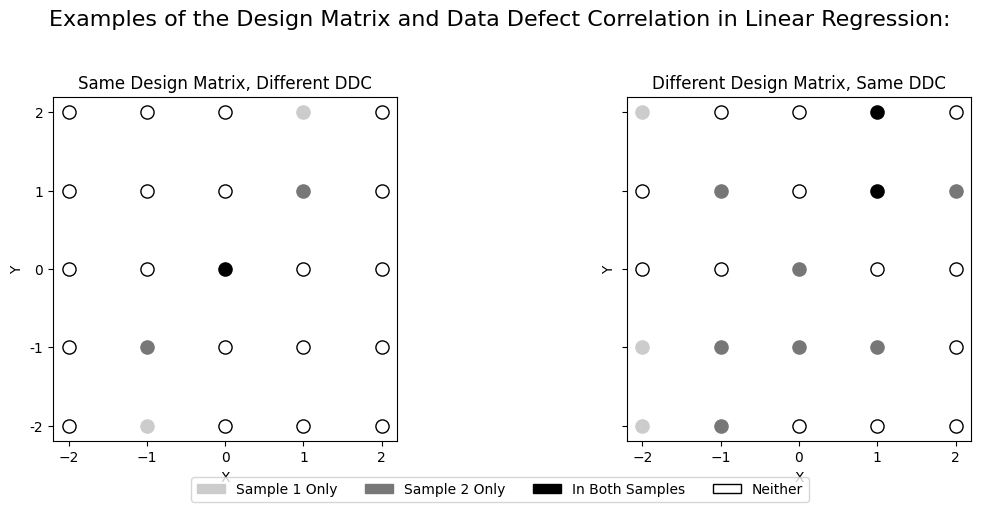

In [38]:
df = pd.DataFrame({
    "X": [i for i in range(-n, n+1)] * (2*n+1),
    "Y": concatenate_lists([[i for _ in range((2*n+1))] for i in range(-n, n+1)])
})

# colors, from lightest to darkest 
C1, C2, C3 = '#CCCCCC', '#777777', '#000000'
# Function to encode memberships for plotting with grayscale
def get_membership_grayscale(df, sample_shape, sample_fill):
    """
    Returns grayscale colors based on membership:
    - Light gray: only in sample_shape
    - Medium gray: only in sample_fill  
    - Dark gray: in both (overlap)
    - White: in neither
    """
    colors = []
    
    for temp_index, temp_row in df.iterrows():
        temp_datapoint = (temp_row['X'], temp_row['Y'])
        in_shape = temp_datapoint in sample_shape
        in_fill = temp_datapoint in sample_fill
        
        if in_shape and in_fill:
            colors.append(C3)  # Black (overlap)
        elif in_shape:
            colors.append(C1)  # Light gray (shape only)
        elif in_fill:
            colors.append(C2)  # Dark gray (fill only)
        else:
            colors.append('white') 
    
    return colors

# Get grayscale colors for both graphs
colors_left = get_membership_grayscale(df, graph1_samples[0], graph1_samples[1])
colors_right = get_membership_grayscale(df, graph2_samples[0], graph2_samples[1])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Left plot (A/B) - use circles with grayscale colors
for x, y, color in zip(df["X"], df["Y"], colors_left):
    if color == 'white':
        axes[0].scatter(x, y, s=90, marker='o', facecolor=color, edgecolor="black", linewidth=1)
    else:
        axes[0].scatter(x, y, s=90, marker='o', facecolor=color, edgecolor=color, linewidth=1)
axes[0].set_title("Same Design Matrix, Different DDC")

# Right plot (C/D) - use circles with grayscale colors
for x, y, color in zip(df["X"], df["Y"], colors_right):
    if color == 'white':
        axes[1].scatter(x, y, s=90, marker='o', facecolor=color, edgecolor="black", linewidth=1)
    else:
        axes[1].scatter(x, y, s=90, marker='o', facecolor=color, edgecolor=color, linewidth=1)
axes[1].set_title("Different Design Matrix, Same DDC")

for ax in axes:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal', adjustable='box')
    
    # ---- Clean up ticks ----
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Overall figure title
fig.suptitle("Examples of the Design Matrix and Data Defect Correlation in Linear Regression:", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle

# Optional: Add legend to explain grayscale coding
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=C1, edgecolor=C1, label='Sample 1 Only'),
    Patch(facecolor=C2, edgecolor=C2, label='Sample 2 Only'),
    Patch(facecolor=C3, edgecolor=C3, label='In Both Samples'),
    Patch(facecolor='white', edgecolor='black', label='Neither')
]
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=4, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend
fig.savefig("design_vs_ddc_ols_example_option4.jpg", dpi=300, bbox_inches='tight')

## option 5:

C:\Users\chess\AppData\Local\Temp\ipykernel_35396\4200404110.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend


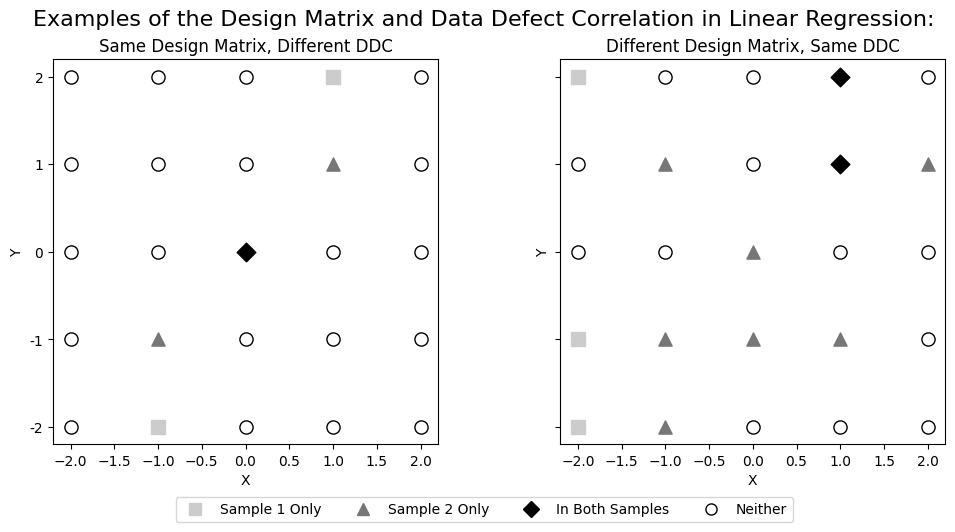

In [42]:
df = pd.DataFrame({
    "X": [i for i in range(-n, n+1)] * (2*n+1),
    "Y": concatenate_lists([[i for _ in range((2*n+1))] for i in range(-n, n+1)])
})

# colors, from lightest to darkest 
C1, C2, C3 = '#CCCCCC', '#777777', '#000000'

# shapes for each category
S1, S2, S3, S4 = 's', '^', 'D', 'o'  # square, triangle, diamond, circle

# Function to encode memberships for plotting with grayscale and shapes
def get_membership_grayscale_shapes(df, sample_shape, sample_fill):
    """
    Returns grayscale colors and shapes based on membership:
    - Light gray + square: only in sample_shape
    - Medium gray + triangle: only in sample_fill  
    - Dark gray + diamond: in both (overlap)
    - White + circle: in neither
    """
    colors = []
    shapes = []
    
    for temp_index, temp_row in df.iterrows():
        temp_datapoint = (temp_row['X'], temp_row['Y'])
        in_shape = temp_datapoint in sample_shape
        in_fill = temp_datapoint in sample_fill
        
        if in_shape and in_fill:
            colors.append(C3)  # Black (overlap)
            shapes.append(S3)  # Diamond
        elif in_shape:
            colors.append(C1)  # Light gray (shape only)
            shapes.append(S1)  # Square
        elif in_fill:
            colors.append(C2)  # Medium gray (fill only)
            shapes.append(S2)  # Triangle
        else:
            colors.append('white')  # White (neither)
            shapes.append(S4)       # Circle
    
    return colors, shapes

# Get grayscale colors and shapes for both graphs
colors_left, shapes_left = get_membership_grayscale_shapes(df, graph1_samples[0], graph1_samples[1])
colors_right, shapes_right = get_membership_grayscale_shapes(df, graph2_samples[0], graph2_samples[1])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Left plot (A/B) - use shapes and grayscale colors
for x, y, color, shape in zip(df["X"], df["Y"], colors_left, shapes_left):
    edge_color = "black" if color == 'white' else color
    axes[0].scatter(x, y, s=90, marker=shape, facecolor=color, edgecolor=edge_color, linewidth=1)
axes[0].set_title("Same Design Matrix, Different DDC")

# Right plot (C/D) - use shapes and grayscale colors
for x, y, color, shape in zip(df["X"], df["Y"], colors_right, shapes_right):
    edge_color = "black" if color == 'white' else color
    axes[1].scatter(x, y, s=90, marker=shape, facecolor=color, edgecolor=edge_color, linewidth=1)
axes[1].set_title("Different Design Matrix, Same DDC")

for ax in axes:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal', adjustable='box')
    
    # ---- Clean up ticks ----
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Overall figure title
fig.suptitle("Examples of the Design Matrix and Data Defect Correlation in Linear Regression:", fontsize=16)

# Create legend with both shapes and colors
import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='black', marker=S1, markersize=8, markerfacecolor=C1, 
                  markeredgecolor=C1, linestyle='None', label='Sample 1 Only'),
    mlines.Line2D([], [], color='black', marker=S2, markersize=8, markerfacecolor=C2, 
                  markeredgecolor=C2, linestyle='None', label='Sample 2 Only'),
    mlines.Line2D([], [], color='black', marker=S3, markersize=8, markerfacecolor=C3, 
                  markeredgecolor=C3, linestyle='None', label='In Both Samples'),
    mlines.Line2D([], [], color='black', marker=S4, markersize=8, markerfacecolor='white', 
                  markeredgecolor='black', linestyle='None', label='Neither')
]

fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=4, fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend

fig.savefig("design_vs_ddc_ols_example_option5.jpg", dpi=300, bbox_inches='tight')

## option 6:

C:\Users\chess\AppData\Local\Temp\ipykernel_11472\855494211.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend


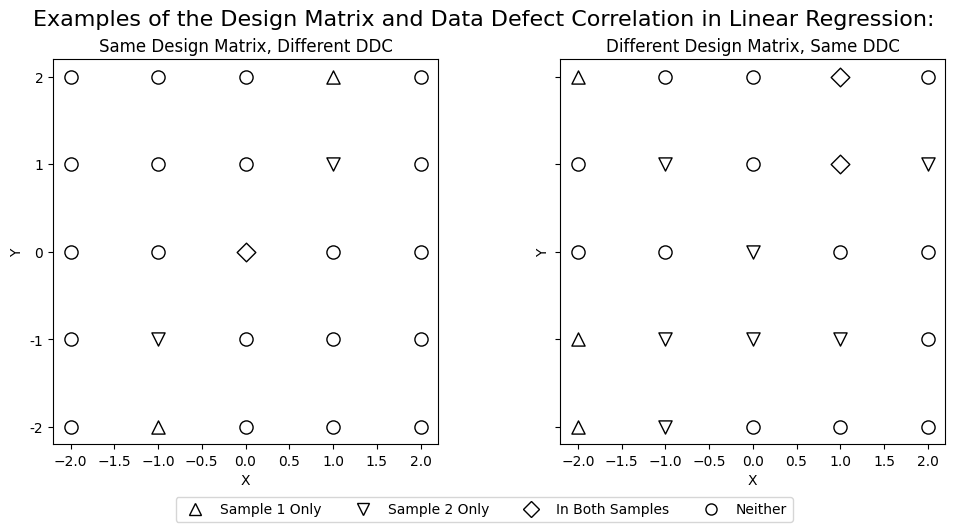

In [11]:
df = pd.DataFrame({
    "X": [i for i in range(-n, n+1)] * (2*n+1),
    "Y": concatenate_lists([[i for _ in range((2*n+1))] for i in range(-n, n+1)])
})

# colors, from lightest to darkest 
C1, C2, C3 = 'white', 'white', 'white'

# shapes for each category
S1, S2, S3, S4 = '^', 'v', 'D', 'o'  # up triangle, down triangle, diamond, circle

# Function to encode memberships for plotting with grayscale and shapes
def get_membership_grayscale_shapes(df, sample_shape, sample_fill, default_color = 'white'):
    """
    Returns grayscale colors and shapes based on membership:
    - Light gray + square: only in sample_shape
    - Medium gray + triangle: only in sample_fill  
    - Dark gray + diamond: in both (overlap)
    - White + circle: in neither
    """
    colors = []
    shapes = []
    
    for temp_index, temp_row in df.iterrows():
        temp_datapoint = (temp_row['X'], temp_row['Y'])
        in_shape = temp_datapoint in sample_shape
        in_fill = temp_datapoint in sample_fill
        
        if in_shape and in_fill:
            colors.append(C3)  # Black (overlap)
            shapes.append(S3)  # Diamond
        elif in_shape:
            colors.append(C1)  # Light gray (shape only)
            shapes.append(S1)  # Square
        elif in_fill:
            colors.append(C2)  # Medium gray (fill only)
            shapes.append(S2)  # Triangle
        else:
            colors.append(default_color)  # White (neither)
            shapes.append(S4)       # Circle
    
    return colors, shapes

# Get grayscale colors and shapes for both graphs
colors_left, shapes_left = get_membership_grayscale_shapes(df, graph1_samples[0], graph1_samples[1])
colors_right, shapes_right = get_membership_grayscale_shapes(df, graph2_samples[0], graph2_samples[1])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Left plot (A/B) - use shapes and grayscale colors
for x, y, color, shape in zip(df["X"], df["Y"], colors_left, shapes_left):
    edge_color = "black" if color == 'white' else color
    axes[0].scatter(x, y, s=90, marker=shape, facecolor=color, edgecolor=edge_color, linewidth=1)
axes[0].set_title("Same Design Matrix, Different DDC")

# Right plot (C/D) - use shapes and grayscale colors
for x, y, color, shape in zip(df["X"], df["Y"], colors_right, shapes_right):
    edge_color = "black" if color == 'white' else color
    axes[1].scatter(x, y, s=90, marker=shape, facecolor=color, edgecolor=edge_color, linewidth=1)
axes[1].set_title("Different Design Matrix, Same DDC")

for ax in axes:
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal', adjustable='box')
    
    # ---- Clean up ticks ----
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Overall figure title
fig.suptitle("Examples of the Design Matrix and Data Defect Correlation in Linear Regression:", fontsize=16)

# Create legend with both shapes and colors
import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([], [], color='black', marker=S1, markersize=8, markerfacecolor=C1, 
                  markeredgecolor='black', linestyle='None', label='Sample 1 Only'),
    mlines.Line2D([], [], color='black', marker=S2, markersize=8, markerfacecolor=C2, 
                  markeredgecolor='black', linestyle='None', label='Sample 2 Only'),
    mlines.Line2D([], [], color='black', marker=S3, markersize=8, markerfacecolor=C3, 
                  markeredgecolor='black', linestyle='None', label='In Both Samples'),
    mlines.Line2D([], [], color='black', marker=S4, markersize=8, markerfacecolor='white', 
                  markeredgecolor='black', linestyle='None', label='Neither')
]

fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=4, fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.10])  # Adjust to make room for legend

fig.savefig("design_vs_ddc_ols_example_option6.jpg", dpi=300, bbox_inches='tight')

## verify ddc, design matrix:

In [133]:
def label_df_with_samples(df, graph1_samples, grp_num: int):
    g1 = []
    g2 = []
    for temp_index, temp_row in df.iterrows():
        temp_datapoint = (temp_row['X'], temp_row['Y'])
        g1.append(True if temp_datapoint in graph1_samples[0] else False)
        g2.append(True if temp_datapoint in graph1_samples[1] else False)
    df[f'grp_{grp_num}_s1'] = pd.Series(g1).astype(int)
    df[f'grp_{grp_num}_s2'] = pd.Series(g2).astype(int)
    return df
    

In [134]:
df = label_df_with_samples(df, graph1_samples, 1)
df = label_df_with_samples(df, graph2_samples, 2)
df['XY'] = df['X'] * df['Y']

In [135]:
# Design Matrix (proportional):
df[["grp_1_s1", "grp_1_s2"]].mul(df["X"] ** 2, axis=0).sum()

grp_1_s1    2
grp_1_s2    2
dtype: int64

In [136]:
# DDC:
corr_with_ddof(df[['grp_1_s1', 'grp_1_s2', 'XY']])

,grp_1_s1,grp_1_s2,XY
grp_1_s1,1.000000,0.242424,0.246183
grp_1_s2,0.242424,1.000000,0.123091
XY,0.246183,0.123091,1.000000


In [137]:
# Design Matrix (proportional):
df[["grp_2_s1", "grp_2_s2"]].mul(df["X"] ** 2, axis=0).sum()

grp_2_s1    14
grp_2_s2    10
dtype: int64

In [138]:
# DDC:
corr_with_ddof(df[['grp_2_s1', 'grp_2_s2', 'XY']])

,grp_2_s1,grp_2_s2,XY
grp_2_s1,1.000000,0.041667,0.25
grp_2_s2,0.041667,1.000000,0.25
XY,0.250000,0.250000,1.00
